<p style="text-align:center; font-size:20px; font-weight:700; font-family: monospace; background-color:rgb(50,50,50); color:rgb(0,255,0); padding:1vh 1vw; border:hidden; border-radius:3px">Projeto 3 - Ciência dos Dados</p>

Alunos:
<ul style="font-family:monospace">
    <li>Cicero Tiago Carneiro Valentim</li>
    <li>Luiz Felipe Lazzaron</li>
    <li>Marcos Vinícius da Silva</li>
    <li>Thalia Loiola Silva</li>
</ul>

In [60]:
# pandas # (comentar)
import pandas as pd 
from pandas.tools.plotting import scatter_matrix 

# numpy # (comentar)
import numpy as np 

# matplotlib #(comentar)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

# (comentar)
import seaborn as sns

# time (calular tempo gasto nos modelos)
from time import time

# warnings (deixar de poluir o documento com warnings)
import warnings
warnings.filterwarnings('ignore')

# scikit-learn (comentar)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler, Imputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

# scikit-learn modelos (comentar)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# função utilizada para exibir os scores dos modelos
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# classe criada para auxiliar as transformações na pipeline
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

%matplotlib inline 

In [131]:
airbnb = pd.read_csv("AB_NYC_2019.csv")

In [132]:
airbnb.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [133]:
# limpar colunas desnecessárias:
airbnb = airbnb.drop(columns=["id","name","host_name","minimum_nights","last_review", 'reviews_per_month', 'calculated_host_listings_count', 'host_id'])

In [134]:
# analisar a coluna "room_type", pois ela parece ser relevante para a análise
airbnb["room_type"].value_counts() # Essa coluna mostrou bastante potencial como variável qualitativa

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [135]:
airbnb.head(2)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,9,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,45,355


### Separação em teste e treinamento

In [136]:
#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#for train_index, test_index in split.split(airbnb, airbnb["room_type"]):
#    strat_train_set = airbnb.loc[train_index] # x_train
#    strat_test_set = airbnb.loc[test_index] # x_test
#    y_train = airbnb["room_type"][test_index] #y_train

In [137]:
#strat_test_set.head(2)

In [138]:
#strat_train_set.head(2)

In [139]:
# airbnb = strat_train_set.drop("price", axis=1)  # df para treinamento
# airbnb_labels = strat_train_set["price"].copy() # "gabarito"

In [140]:
#airbnb_labels.head()

In [141]:
airbnb.head(2)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,number_of_reviews,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,9,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,45,355


In [147]:
airbnb_labels = airbnb["price"]
airbnb_labels.head()

0    149
1    225
2    150
3     89
4     80
Name: price, dtype: int64

In [148]:
airbnb_treinamento = airbnb.drop("price", axis=1)

In [149]:
airbnb_treinamento.shape, airbnb_labels.shape

((48895, 7), (48895,))

In [154]:
# where magic happens
num_attribs = list(airbnb.drop(columns=["neighbourhood_group","neighbourhood","room_type", "price"]).columns)
cat_attribs = ["neighbourhood_group","neighbourhood","room_type"]

num_pipeline = Pipeline([
    ( 'selector', DataFrameSelector(num_attribs) ),
    ('imputer', SimpleImputer(strategy="median")),
    ( 'std_scaler', StandardScaler() )
])
cat_pipeline = Pipeline([
    ( 'selector', DataFrameSelector(cat_attribs) ),
    ( 'label_encoder', LabelEncoder())
])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
])

In [155]:
airbnb_prepared = full_pipeline.fit_transform(airbnb_treinamento)

In [156]:
airbnb_prepared

<48895x233 sparse matrix of type '<class 'numpy.float64'>'
	with 342265 stored elements in Compressed Sparse Row format>

In [157]:
# separar em uma nova base de treinamento e teste:
# X_train, y_train -> bases utilizadas para treinamento do modelo 
# x_test -> base usada para prever valores do ´roce
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(airbnb_prepared, airbnb_labels, test_size=0.33, random_state=RANDOM_SEED)

In [158]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32759, 233), (16136, 233), (32759,), (16136,))

In [159]:
some_labels = airbnb_labels.iloc[:5]

In [160]:
some_data = airbnb.iloc[:5] # analise das 8 primeiras linhas

In [161]:
# preparação de some_data apenas para teste futuro
some_data_prepared = full_pipeline.transform(some_data)

<hr><p style="text-align:center; font-size:20px; font-weight:700; font-family: monospace">K-Neighbors Regressor</p><hr>

Esse tipo de algoritmo pode ser utilizado tanto para classificações como para regressões. Nesse caso, como o próprio título já sugere, o modelo será focado em uma regressão, de tal forma que se consiga prever o preço de determinada residência tomando como base em uma medida de similaridade.

In [162]:
from sklearn.neighbors import KNeighborsRegressor
import mglearn 

De forma simplificada, esse modelo trabalhará da seguinte forma:

O "test prediction" mostrado abaixo refere-se a variável na qual se quer prever. Essa variável será prevista pela k-neighbors regressor com base nos pontos de treinamento próximos a ela. Para a escolha dos pontos, deve-se mudar o valor dado ao argumento "n_neighbors", visto no comando abaixo. 

Vale ressaltar, no entanto, que um valor alto dado para esse argumento não implica necessariamente em uma melhoria do modelo. Portanto, a escolha desse valor deve ser feita de forma criteriosa para que se possa chegar a melhor predição possível.

###### n_neighbors = 7

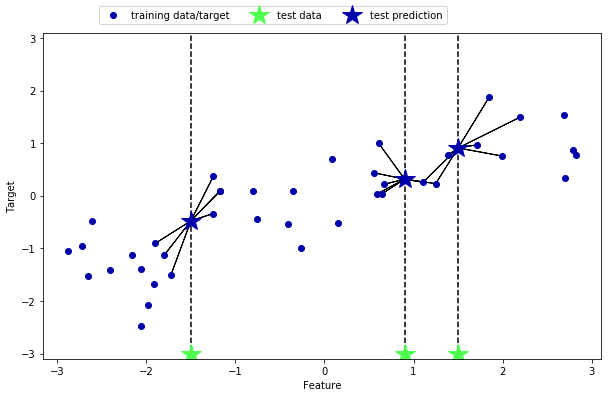

In [163]:
mglearn.plots.plot_knn_regression(n_neighbors=7)

###### n_neighbors = 3

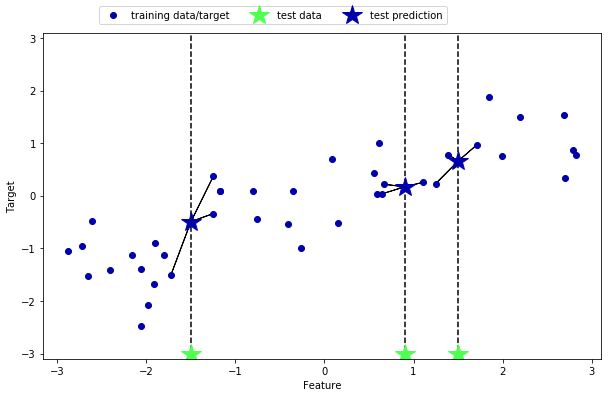

In [164]:
mglearn.plots.plot_knn_regression(n_neighbors=3);

In [170]:
k_reg = KNeighborsRegressor(n_neighbors=3)

In [171]:
k_reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=3, p=2,
          weights='uniform')

In [172]:
print("Predictions:\t", list(k_reg.predict(some_data_prepared)))
print("Labels:\t\t", list(some_labels))

Predictions:	 [66.0, 489.6666666666667, 103.33333333333333, 153.0, 146.66666666666666]
Labels:		 [149, 225, 150, 89, 80]


Abaixo, a função .predict será utilizada para prever, com base no modelo que está sendo usado, os preços do novo banco de dados que foi preparado acima, chamado "airbnb_prepared".

In [173]:
airbnb_predictions = k_reg.predict(X_test)

In [ ]:
for n in range(2, 10):
    k_reg = KNeighborsRegressor(n_neighbors= n)
    k_reg.fit(X_train, y_train)
    airbnb_predictions = k_reg.predict(X_test)
    r2_knn = r2_score(y_test, airbnb_predictions)
    print("Para n = {0}: R² = {1}".format(n, r2_knn))

In [174]:
r2_knn = r2_score(y_test, airbnb_predictions)
print("R² = {}".format(r2_knn))

R² = -0.20753847871101216


In [92]:
time_init = time()

k_reg_scores = cross_val_score(k_reg, airbnb_prepared, airbnb_labels, cv=10)

print("\nTempo gasto: {:.2f} segundos".format(time() - time_init))


Tempo gasto: 229.37 segundos


In [94]:
k_reg_scores

array([0.98235499, 0.9870799 , 0.98006828, 0.98170868, 0.97059964,
       0.98547258, 0.98552021, 0.98226218, 0.98759549, 0.97861905])

In [95]:
display_scores(k_reg_scores)

Scores: [0.98235499 0.9870799  0.98006828 0.98170868 0.97059964 0.98547258
 0.98552021 0.98226218 0.98759549 0.97861905]
Mean: 0.9821280999748174
Standard deviation: 0.004762476730101714


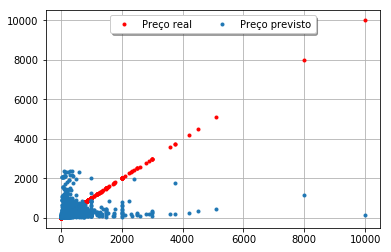

In [177]:
ax = plt.subplot(111)
plt.plot(y_test, y_test, 'r.', label='Preço real')
plt.plot(y_test, airbnb_predictions, '.', label='Preço previsto')
plt.grid(True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
plt.show()

conclusao modelo geral:

Vale ressaltar que a análise da predição dos preços das residências foi feita tomando como base diversas variáveis que estavam relacionadas com o residencial. Por exemplo, pode-se afirmar, de acordo com o senso comum, que para uma mesma empresa, um airbnb que abrigue 2 pessoas será mais caro que aquele que é individual. Em vista disso, muitas váriaveis foram utilizadas para análise, de forma que os modelos acima pudessem prever valores mais próximos dos reais.


Poderíamos realizar atividades para melhorar o desempenho do modelo, cada projeto que realizamos demanda uma precisão, muitas vezes teremos de realizar o treinamento do modelo de maneira iterativa, comparando algoritmos, testando novas variáveis preditoras, criando novas variáveis, obtendo mais dados ou realizando manipulações no conjunto de dados antes do trabalho ser finalizado. Lembrando sempre que a precisão do modelo deve atender ao necessário para resolver o problema de negócios em que estamos trabalhando.